<a href="https://colab.research.google.com/github/SHA152/time_series_forecasting_SARIMA/blob/main/VPS_ARIMA%2C_SARIMA_and_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful Functions

In [2]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")


In [3]:
# Function to assess model and visualize output
def model_prediction_graph(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

In [4]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Plot training and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Libraries and Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX

/content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX


In [7]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.9 MB/s eta 0:00:00


In [8]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from pmdarima.arima import auto_arima, ARIMA
from pmdarima import model_selection # Import model_selection directly from pmdarima

In [9]:
# Loading the Data and Setting the Index
df = pd.read_csv("vps.csv", index_col = "Month", parse_dates = True, dayfirst=True)
df.head()

<ipython-input-9-73df5c838ab5>:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv("vps.csv", index_col = "Month", parse_dates = True, dayfirst=True)


,adds
Month,
2017-12-31,823
2018-01-31,939
2018-02-28,808
2018-03-31,841
2018-04-30,939


In [10]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2017-12-31 to 2024-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   adds    81 non-null     int64
dtypes: int64(1)
memory usage: 1.3 KB


In [11]:
# Setting the Frequency
df = df.asfreq("M")

In [12]:
# Change the time Series variable name
df = df.rename(columns = {'adds': 'y'})
df.head()

,y
Month,
2017-12-31,823
2018-01-31,939
2018-02-28,808
2018-03-31,841
2018-04-30,939


In [18]:
# Transform revenue into a float and assign it back to the column
# Check if the column is of type object (string) before applying str methods
if df['y'].dtype == object:
    df['y'] = df['y'].str.replace(",","").astype(float)
else:
    print("Column 'y' is already numeric. Skipping string conversion.")

Column 'y' is already numeric. Skipping string conversion.


# Exploratory Data Analysis

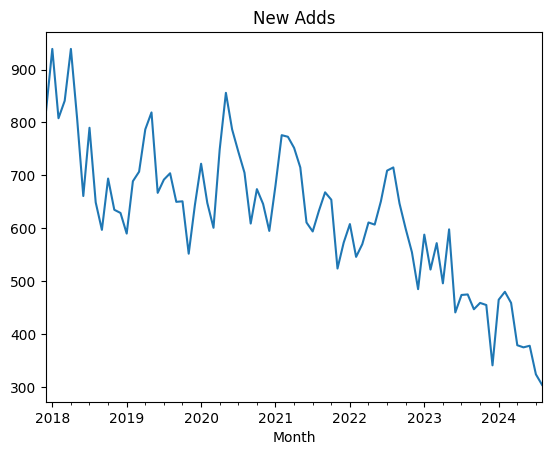

In [19]:
# Daily Closing Price  Plot
df['y'].plot(title = 'New Adds')
plt.show()

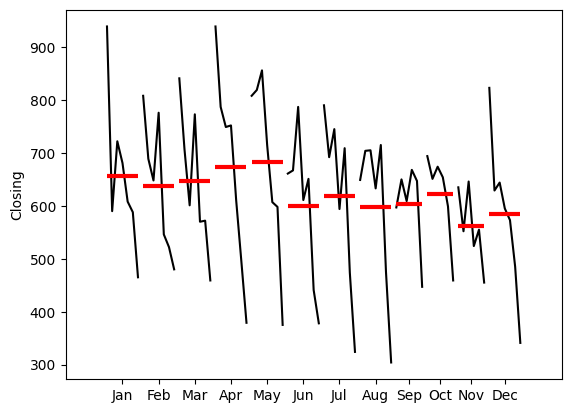

In [20]:
# Plotting the monthly seasonality
month_plot(df['y'].resample('M').mean(),
           ylabel = 'Closing')
plt.show()

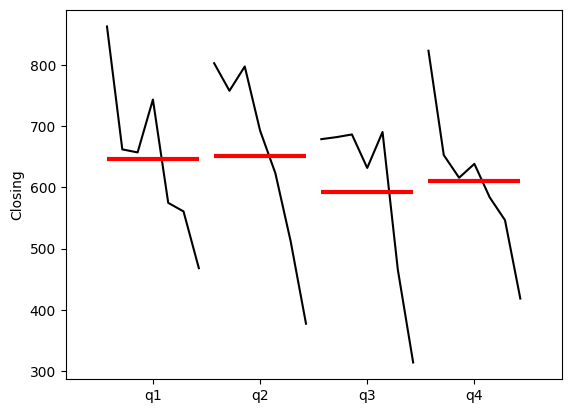

In [21]:
# Plotting the quarterly seasonality
quarter_plot(df['y'].resample('Q').mean(),
           ylabel = 'Closing')
plt.show()

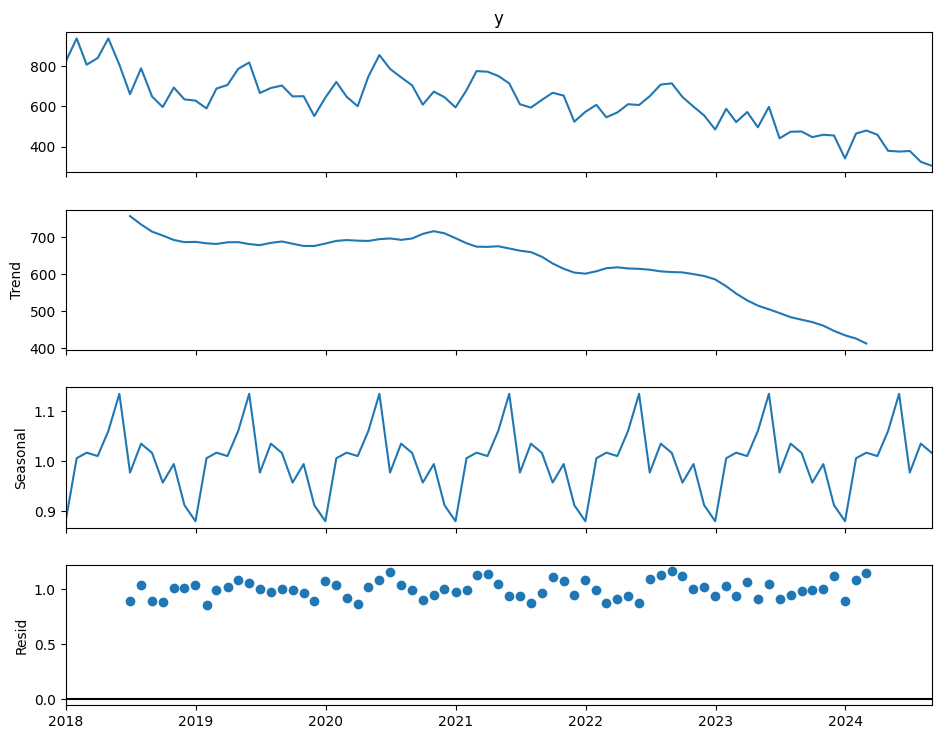

In [22]:
# Seasonal Decomposition Plots
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

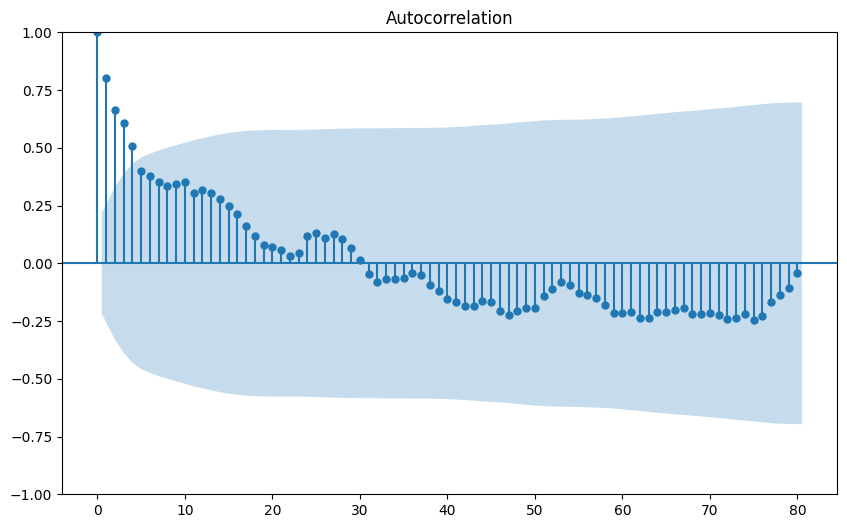

In [23]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10,6))
# Set lags to be less than or equal to the length of the DataFrame
plot_acf(df['y'], lags = len(df) -1 , ax = ax)
plt.show()

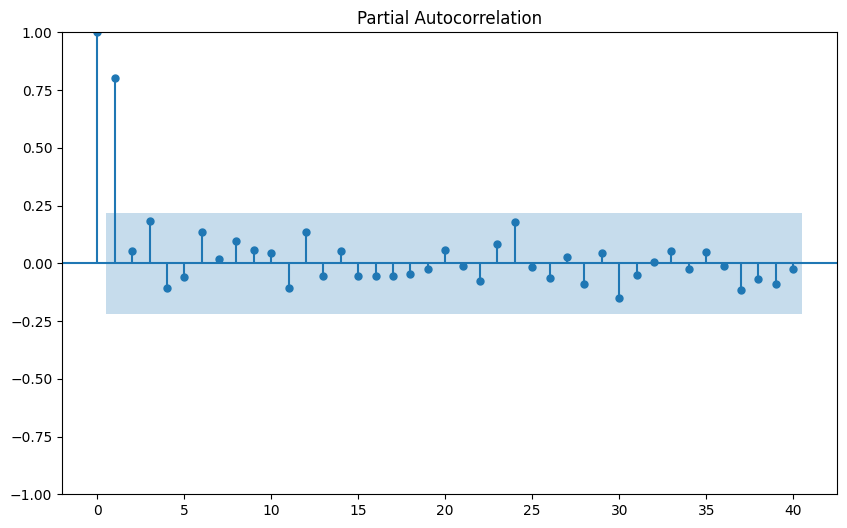

In [24]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10,6))
# Calculate maximum lag based on 50% of data length
max_lag = len(df) // 2  # Use floor division to ensure integer result
# Use min to select the smaller value between max_lag and original lags
plot_pacf(df['y'], lags = min(100, max_lag), ax = ax)
plt.show()

# Checking Stationarity

In [27]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the 'y' column of the DataFrame
adf_test_result = adfuller(df['y'])

# Extract the test statistic, p-value, used lags, and number of observations
adf_statistic = adf_test_result[0]
p_value = adf_test_result[1]
used_lag = adf_test_result[2]
n_obs = adf_test_result[3]
critical_values = adf_test_result[4]  # Critical values for different significance levels

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Number of Lags Used: {used_lag}')
print(f'Number of Observations Used: {n_obs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpretation of the ADF test results
if p_value < 0.05:
    print("The time series is stationary. Reject the null hypothesis (H0).")
else:
    print("The time series is non-stationary. Fail to reject the null hypothesis (H0).")

ADF Statistic: -2.203237769212329
p-value: 0.2050724328580948
Number of Lags Used: 0
Number of Observations Used: 80
Critical Values:
   1%: -3.5148692050781247
   5%: -2.8984085156250003
   10%: -2.58643890625
The time series is non-stationary. Fail to reject the null hypothesis (H0).


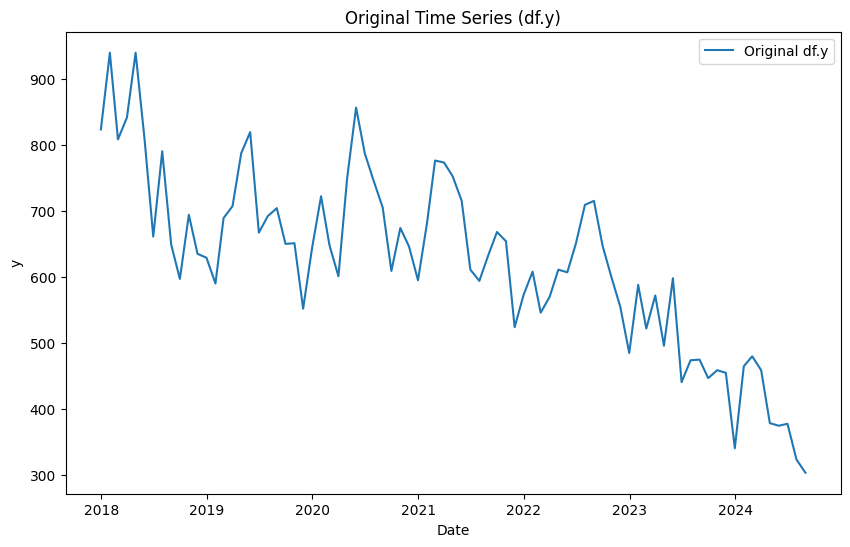

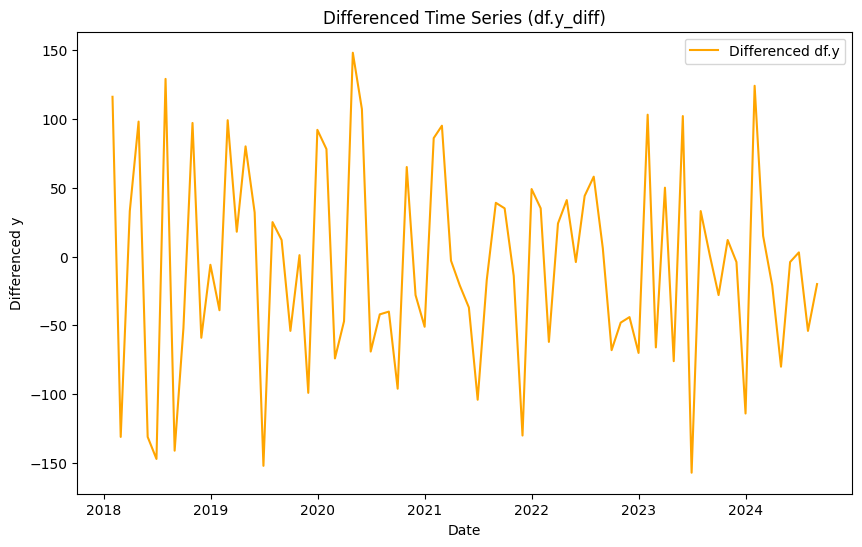

In [28]:
# Doing the first differencing

# Plot the original time series
plt.figure(figsize=(10, 6))
plt.plot(df['y'], label='Original df.y')
plt.title('Original Time Series (df.y)')
plt.xlabel('Date')
plt.ylabel('y')
plt.legend()
plt.show()

# Apply first differencing to make the time series stationary
df['y_diff'] = df['y'].diff().dropna()

# Plot the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(df['y_diff'], label='Differenced df.y', color='orange')
plt.title('Differenced Time Series (df.y_diff)')
plt.xlabel('Date')
plt.ylabel('Differenced y')
plt.legend()
plt.show()


In [29]:
# Perform the Augmented Dickey-Fuller test on the 'y' column of the DataFrame
adf_test_result = adfuller(df['y_diff'].dropna())

# Extract the test statistic, p-value, used lags, and number of observations
adf_statistic = adf_test_result[0]
p_value = adf_test_result[1]
used_lag = adf_test_result[2]
n_obs = adf_test_result[3]
critical_values = adf_test_result[4]  # Critical values for different significance levels

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Number of Lags Used: {used_lag}')
print(f'Number of Observations Used: {n_obs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpretation of the ADF test results
if p_value < 0.05:
    print("The time series is stationary. Reject the null hypothesis (H0).")
else:
    print("The time series is non-stationary. Fail to reject the null hypothesis (H0).")

ADF Statistic: -4.291483777323987
p-value: 0.0004595408190102064
Number of Lags Used: 10
Number of Observations Used: 69
Critical Values:
   1%: -3.528889992207215
   5%: -2.9044395987933362
   10%: -2.589655654274312
The time series is stationary. Reject the null hypothesis (H0).


# SARIMA Model

In [30]:
# Split the Data into training and test
test_months = 12
train, test = df.iloc[:-test_months], df.iloc[-test_months:]
test


,y,y_diff
Month,,
2023-09-30,447,-28.0
2023-10-31,459,12.0
2023-11-30,455,-4.0
2023-12-31,341,-114.0
2024-01-31,465,124.0
2024-02-29,480,15.0
2024-03-31,459,-21.0
2024-04-30,379,-80.0
2024-05-31,375,-4.0


# SARIMA

In [31]:
# Assuming 'train' is your DataFrame with a 'y' column containing the time series data

# Run auto_arima to find the best SARIMA parameters for monthly data
model_SARIMA = auto_arima(train['y'],
                           m=12,  # Set seasonality to 12 for monthly data
                           seasonal=True,
                           start_p=0, start_q=0, max_p=3, max_q=3,
                           start_P=0, start_Q=0, max_P=3, max_Q=3,
                           d=1, D=1,
                           trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the model summary
model_SARIMA.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=676.714, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=654.250, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=678.103, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=654.661, Time=1.53 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=654.143, Time=2.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=655.993, Time=1.92 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=655.140, Time=0.59 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=657.983, Time=1.71 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=654.562, Time=0.25 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=653.403, Time=0.50 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=653.57

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -320.671
Date:                            Fri, 27 Sep 2024   AIC                            651.342
Time:                                    16:27:59   BIC                            661.468
Sample:                                12-31-2017   HQIC                           655.268
                                     - 08-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5442      0.248      2.191      0.028       0.057       1.031
ma.L1         -0.8749      0.208     -4.208      0.000      -1.282      -0.467
ar.S.L12      -0.4579      0.169     -2.711      0.007      -0.789      -0.127
ma.S.L12      -0.3921      0.229     -1.712      0.087      -0.841       0.057
sigma2      4668.4251   1005.778      4.642      0.000    2697.136    6639.714
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.41
Prob(Q):                              0.91   Prob(JB):                         0.49
Heteroskedasticity (H):               0.66   Skew:                             0.30
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Assuming 'model_SARIMA' is the fitted SARIMA model
# Get predictions
predictions_sarima = model_SARIMA.predict(n_periods=test_months)

# # Optionally, if you need the predictions as a pandas Series with the correct index:
# predictions_sarima = pd.Series(predictions_sarima, index=test.index)  # Assuming 'test' is your test DataFrame

# Display the predictions
print(predictions_sarima)


2023-09-30    474.751102
2023-10-31    487.375683
2023-11-30    402.362822
2023-12-31    418.078082
2024-01-31    477.329183
2024-02-29    451.095919
2024-03-31    468.177308
2024-04-30    490.086805
2024-05-31    503.824251
2024-06-30    469.005923
2024-07-31    499.869742
2024-08-31    506.233970
Freq: M, dtype: float64


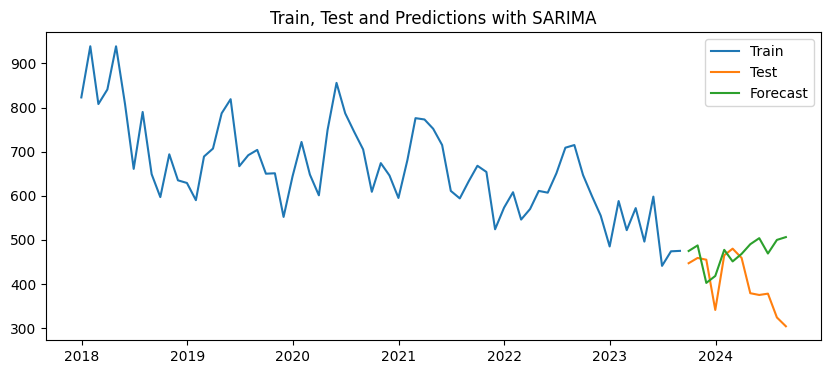

The MAE is 78.77
The RMSE is 100.17
The MAPE is 22.15 %


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
# Model Assessment
model_assessment(train['y'], test['y'], predictions_sarima, "SARIMA")

In [34]:
# Assuming 'test_months' is the number of periods you want to predict
# And 'model_SARIMA' is your fitted SARIMA model
SARIMA_Model_VPS = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), suppress_warnings=True)
SARIMA_Model_VPS = SARIMA_Model_VPS.fit(train['y'])  # Fit the model to the training data

# Get predictions using the 'predict' method
predictions_sarima_VPS = SARIMA_Model_VPS.predict(n_periods=48)

# Optionally, if you need the predictions as a pandas Series with the correct index:
# predictions_sarima = pd.Series(predictions_sarima_VPS, index=pd.date_range(start=train.index[-1], periods=48, freq='MS'))  # Assuming 'test' is your test DataFrame and your data is monthly

# Display the predictions
print(predictions_sarima_VPS)

2023-09-30    480.442618
2023-10-31    494.897549
2023-11-30    411.535186
2023-12-31    428.180476
2024-01-31    487.863910
2024-02-29    459.664333
2024-03-31    476.987200
2024-04-30    496.076579
2024-05-31    509.100084
2024-06-30    474.612786
2024-07-31    505.047291
2024-08-31    510.379819
2024-09-30    471.315372
2024-10-31    449.792850
2024-11-30    380.583879
2024-12-31    353.196838
2025-01-31    430.986633
2025-02-28    383.103517
2025-03-31    414.314687
2025-04-30    387.179832
2025-05-31    440.973371
2025-06-30    347.510557
2025-07-31    378.049831
2025-08-31    380.259703
2025-09-30    361.141579
2025-10-31    355.550462
2025-11-30    278.618809
2025-12-31    270.975897
2026-01-31    339.184087
2026-02-28    299.557132
2026-03-31    323.180165
2026-04-30    316.829827
2026-05-31    350.348546
2026-06-30    283.689250
2026-07-31    313.147363
2026-08-31    315.799453
2026-09-30    286.235463
2026-10-31    272.093484
2026-11-30    197.775293
2026-12-31    179.782018


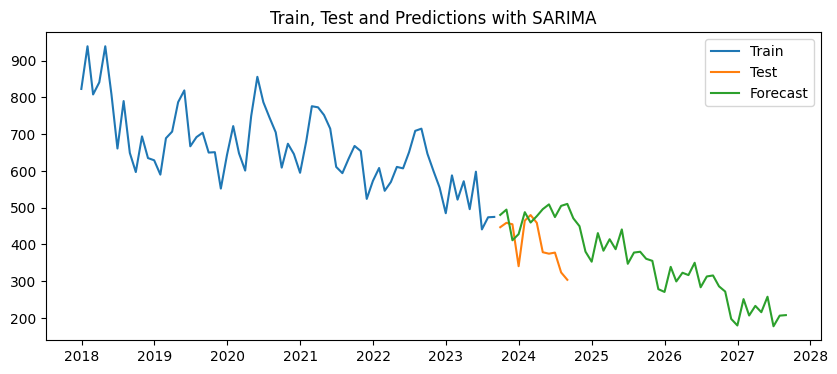

In [36]:
# Model Assessment
model_prediction_graph(train['y'], test['y'], predictions_sarima_VPS, "SARIMA")